# Mapping galaxies' 3D positions

In this notebook, we'll use a bunch of data downloaded from SDSS -- the Sloan Digital Sky Server. We'll organize it, convert redshift to distance, and then export it the standard file type used by planetarium software.

First, let's again import all of the modules we will need.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance, Angle
from astropy.table import Table, Column
from astropy.io import ascii
import seaborn as sns
from astropy.cosmology import Planck13
import numpy as np
sns.set()
%matplotlib inline

### "Querying" SDSS
Next, we have to query our data from SDSS using CasJobs. "Querying" is a term for running a script that will download, from a larger data set, only the data you need. On the database we can see all the different parameters that are available to be queried. We will download the ones necessary to locate its position (RA, Dec, and redshift -- which will give us distance), and some properties of the galaxies, like spectro_Flux_r / i (flux in red / infrared band). The following SQL script will select these data for us.
```
SELECT gz.ra, gz.dec, sp.z, sp.spectroFlux_r as r, 
  sp. spectroFlux_i as i into mydb.galaxydata from DR10.zooSpec as gz 
  JOIN  DR8.specObjAll as sp on sp.specobjid=gz.specobjid
WHERE sp.zWarning=0 and sp.z >0.0005
```
You don't have to do anything with this^. Just download the table: galaxies_archiekinnane.fit.

We open, inspect, and read in the data from the fits file. We see that all of our columns made it in.

In [2]:
hdu1 = fits.open("galaxies_archiekinnane.fit")
hdu1.info()
print(hdu1[1].columns)

Filename: galaxies_archiekinnane.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     18   665225R x 5C   [1E, 1E, 1E, 1E, 1E]   
ColDefs(
    name = 'ra'; format = '1E'
    name = 'dec'; format = '1E'
    name = 'z'; format = '1E'
    name = 'r'; format = '1E'
    name = 'i'; format = '1E'
)


Let's put it in a neat astropy Table and take a look at what we have.

In [3]:
galaxies = Table(hdu1[1].data)
hdu1.close()

In [4]:
galaxies

ra,dec,z,r,i
float32,float32,float32,float32,float32
146.85983,-0.8089167,0.12655362,35.343086,66.24687
146.96391,-0.5450278,0.055987872,19.022448,29.305738
146.72795,-0.5568611,0.08933747,58.950886,95.62222
146.74413,-0.6522222,0.2037688,34.441887,58.641396
146.59271,-0.76025,0.06502353,52.444443,75.21119
146.93413,-0.67041665,0.12131637,76.42564,120.61376
146.95,-0.5922222,0.064776674,32.779373,48.20951
146.62859,-0.76513886,0.064588785,72.8277,114.54557
146.85771,-0.6628889,0.08439621,12.33995,17.28294


Next, we want to convert our redshifts into distances using an astropy method called Planck13.comoving_distance. 

There are a few ways to calculate distances. Lookback-time distance is how long it took the light we are seeing to reach us. Luminosity distance is the distance -- found using inverse square law -- that the galaxies would emit at their observed brightness. Comoving distances scale out the expansion of the universe. If we were able to stop the expansion of the universe and go and measure the distance to galaxies that is what we would get.

We also convert our RA (in degrees) into an RA in hours by dividing by 15, just to have it. We add these columns to our table.

In [5]:
galaxies.add_column(Column(Planck13.comoving_distance(galaxies['z']),name='distance'))
galaxies.add_column(Column(galaxies['ra']/15.,name='ra_h'))

We also want to create a column of coordinate distances, which will make it much easier to convert between coordinate systems later. We use the astropy method SkyCoord to create this column of objects. You can input 'locations' to SkyCoord using whatever coordinate system you currently have your data in -- for us, that means RA, Dec, and comoving distance. Then, you just have to specify what it is that you gave SkyCoord, which we do using "frame = 'icrs'", which is basically the J2000 equatorial frame -- what our RA and Dec values are referential to.

In [6]:
coordsCol=SkyCoord(galaxies['ra'],galaxies['dec'],unit=(u.degree, u.degree),distance=Distance(galaxies['distance'],u.pc),frame='icrs')

In [ ]:
galaxies.add_column(Column(22.5 - 2.5*np.log10(galaxies['r']), name = 'mag'))

### Converting to magnitudes
Finally, we want to convert our luminosity units (nanomaggies) into typical magnitudes. The formula to do so is:
```
Magnitude = 22.5 - 2.5 * log(L in nanomaggies)
```
You might notice that this means that the brighter something is (higher nanomaggies) the lower magnitude it has. This is an extremely annoying astronomy convention.

Add a column below based on this conversion. Name it 'mags'.

In [ ]:
galaxies.add_column(Column(22.5 - 2.5*np.log10(galaxies['r']), name = 'mag'))

In [13]:
galaxies

ra,dec,z,r,i,distance,ra_h,mag
,,,,,Mpc,,
float32,float32,float32,float32,float32,float64,float32,float32
146.85983,-0.8089167,0.12655362,35.343086,66.24687,543.0769012063781,9.790655,18.629238
146.96391,-0.5450278,0.055987872,19.022448,29.305738,244.42833305459004,9.797594,19.301834
146.72795,-0.5568611,0.08933747,58.950886,95.62222,386.8954327702805,9.781863,18.073774
146.74413,-0.6522222,0.2037688,34.441887,58.641396,857.5735534565894,9.782942,18.657282
146.59271,-0.76025,0.06502353,52.444443,75.21119,283.2608817875246,9.772847,18.200752
146.93413,-0.67041665,0.12131637,76.42564,120.61376,521.2781747213573,9.7956085,17.791903
146.95,-0.5922222,0.064776674,32.779373,48.20951,282.20227521436124,9.796666,18.710999
146.62859,-0.76513886,0.064588785,72.8277,114.54557,281.3964438866701,9.775239,17.844257


And write a VOtable, a standard format for astronomical catalog data.

In [14]:
#only run this if file isn't created yet

galaxies.write('galaxydata2.xml',format='votable')

Add some units

In [10]:
galaxies['ra'] = galaxies['ra']*u.degree
galaxies['dec'] = galaxies['dec']*u.degree
galaxies['ra_h'] = galaxies['ra_h']*u.hour

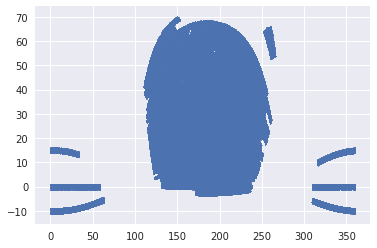

In [11]:
plt.plot(galaxies['ra'], galaxies['dec'], 'o', markersize = 1)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


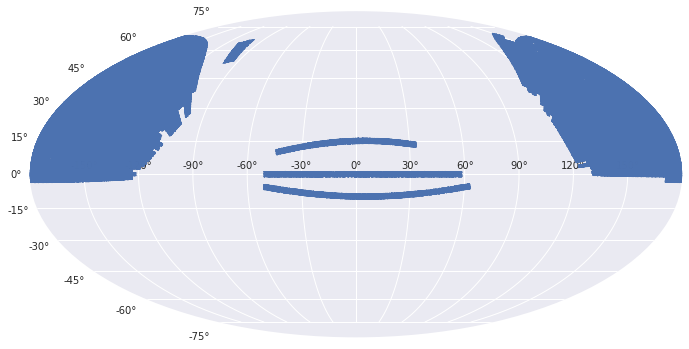

In [12]:
import numpy as np
fig = plt.figure (figsize=(13,6))
ax = fig.add_subplot(111,projection="mollweide")
plt.scatter(Angle(galaxies['ra_h'],u.hr).wrap_at(180.*u.deg).radian, Angle(galaxies['dec'],u.deg).radian,
            s=0.1*np.log(galaxies['r']))

Text(0.5,0,'i band magnitude (nanomaggies)')

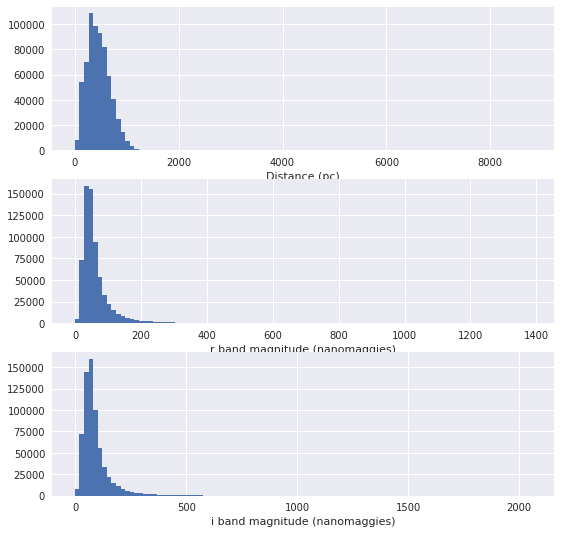

In [14]:
fig = plt.figure (figsize=(9,9))
ax = fig.add_subplot(311)
ax.hist(galaxies['distance'],bins=100)
ax.set_xlabel("Distance (pc)")
a2 = fig.add_subplot(312)
a2.hist(galaxies['r'],bins=100)
a2.set_xlabel("r band magnitude (nanomaggies)")
a3 = fig.add_subplot(313)
a3.hist(galaxies['i'],bins=100)
a3.set_xlabel("i band magnitude (nanomaggies)")

In [15]:
print (coordsCol[1])
print (coordsCol[1].galactic)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (146.96391296, -0.54502779, 2.44428333e+08)>
<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    (237.33751746, 37.95468424, 2.44428333e+08)>
